L. Drew Hill

CE263N - Problem 5

Nov. 19, 2016

<Strong> Short Report </Strong>

For this problem set, I wrote a program to read each person's tweet file into Python, one file at a time. Latitude, longitude, datetime, and text were read from each file. I then produced from these data a series of features to plug into a Gaussian Mixed Model. First, I produced a feature identifying the hour of the day during which each tweet was sent. Then, I produced a feature to tell whether a tweet was sent during a work hours, which I defined as 9am to 6pm, Monday through Friday. I then established a pool of words that I would expect to be included in 1) a tweet posted from work and 2) a tweet posted from home. Two binary variables were then created to determine whether a tweet had included a word from the work pool (variable 1) or the home variable (variabvle 2). With these variables, a Gaussian Mixed Model was produced, and, using cross-validation, the approprite number of clusters (n_components) b etween 1 and 10, as well as the most approprite type of variation ('spherical', 'tied', 'diag', 'full') was established. Commuter status ws determined by examining the number of tweets belonging to ech cluster and comparing that, as a fraction, to the total number of tweets. If at least two clusters contained more than 27% of the tweets each (representing five days a week at 9 hours a day), then it was assumed that person was a commuter (i.e. they spent at least 9 hours a day five days a week at work, and then at least that much or more at home). Worth noting is that this assumes that the number of tweets from an cluster are proportional to total time spent in that cluster. The tope two clusters were assumed to includ both work and home locations, as I assumed that the two places in which a person spends most of their time are home and work (or school). For those people determined to be 'commuters', home vs. work was established according to the time of tweet from that cluster. If the mode (most frequent) time of tweet of the largest cluster was on a workday between 9am and 5pm, then that cluster was identified as a work location. Otherwise, it was determined a home cluster. Typical time of day at work/school and home were taken as the mode (most frequent) tweet time from the respective cluster. Coordinates of work and home were taken as the mean lat and lon of the tweets in those respective (work and home) clusters.

In [5]:
from os import listdir
import datetime
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import itertools
from scipy import linalg
from scipy import stats
from sklearn import mixture
from sklearn.externals.six.moves import xrange

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [6]:
# list all CSV files
path =r'new_york'
allFiles = glob.glob(path + "/*.csv")

In [7]:
# # concatenate into a single data frame
# df = pd.DataFrame()
# list_ = []
# for file_ in allFiles:
#         # read in one file at a time
#     df_interim = pd.read_table(file_, usecols=np.arange(0,4),delimiter = ',', header = None, names = ['datetime','lat','lon','text'])
#         #create name column
#     df_interim['name'] = file_.split('/',)[1].split('.')[0]
#         # convert datetime format
#     df_interim['datetime'] = pd.to_datetime(df_interim['datetime'], format='%Y-%m-%d %H:%M:%S')
#         # append files one at a time to master file
#     list_.append(df_interim)
# df = pd.concat(list_)

# # make numpy array
# data = df.values

In [12]:
## Time function
def t_dist(str1, str2):
   
    t1 = datetime.datetime.strptime(str1, '%Y-%m-%d %H:%M:%S')
    t2 = datetime.datetime.strptime(str2, '%Y-%m-%d %H:%M:%S')
   
    if t2>t1:
        return (t2-t1).total_seconds()
    else:
        return (t1-t2).total_seconds()

## Function for reading in files one at a time
def read_drew(file_):
    d, timestr = [], []
    # readLines each file individually
    with open(file_,'r') as f:
        for line in f:  
            l = line.strip().split(',')
            
            timestr.append( datetime.datetime.strptime(l[0], '%Y-%m-%d %H:%M:%S') )
            d.append([float(l[1]), float(l[2]),t_dist(l[0], '1970-01-01 00:00:00'), l[3] ])
    
    #############
    # create array
    d = np.array(d)
    
    #############
    # create features
    datetime_labels = [datetime.datetime.fromtimestamp( float(lab) ) for lab in d[:,2]]
    datetime_hours = [float(h.hour) for h in datetime_labels]
    datetime_wday = [float(h.weekday()) for h in datetime_labels]    
    
#     # weekend
#     work_days = []
#     for day in datetime_wday:
#         if day > 4:
#             work_days.append(float(0))
#         else:
#             work_days.append(float(1))    

    # home-based words from text
    home_words = ['home','dorm','house','sleep','bed','TV','goodnight','goodmorning']
    home_label = []
    for home_txt in d[:,3]:
        test = []
        for i in home_words:
            if i in home_txt:
                test.append(float(1))
            else:
                test.append(float(0))
        if sum(test) >0 :
            home_label.append(float(1))
        else:
            home_label.append(float(0))

    # home-based words from text
    work_words = ['work','job','boss','coworker','co-worker','corporate',
                  'meeting','conference','class','professor','projector',
                 'library','office','ta','gsi','college','university',
                 'bookstore','bus','bart','subway','train','lunch']
    work_label = []
    for work_txt in d[:,3]:
        test = []
        for i in work_words:
            if i in work_txt:
                test.append(float(1))
            else:
                test.append(float(0))
        if sum(test) >0 :
            work_label.append(float(1))
        else:
            work_label.append(float(0))
    
    
    # weekends
    weekend = []
    for day in datetime_wday:
        if day > 4:
            weekend.append(float(1))
        else:
            weekend.append(float(0))

            
    # work hours (only applies to weekdays)
    work_hours = []
    for day in datetime_wday:
        if day < 5:
            for hour in datetime_hours:
                if hour > 8 and hour < 18:
                    work_hours.append(float(1))
                else:
                    work_hours.append(float(0))
        else:
            work_hours.append(float(0))
            
            
    ##############        
    # append features to d
    one = np.array(zip(datetime_hours,home_label,work_label,work_hours))
    d = np.concatenate((d,one), 1)

        # ### columns of d = 
    #     0: latitude
    #     1: longitude
    #     2: datetime
    #     3: text
    #     4: datetime_hours 
    #     5: home_label
    #     6: work_label
    #     7: work_hours
    
    
#     ##############
#     # GMM prediction of location clusters using CV to determine:
#         # number of components (1 or 2)
#         # best model type (spherical, tied, diag, full)
 
    X = d[:,[0,1,4,5,6,7]]
    X = X.astype(np.float)

###
### GMMDirichtelet  
###  
    
#     max_loglik = np.negative(np.infty)
#     loglik = []
#     n_components_range = range(1, 3)
#     cv_types = ['spherical', 'tied', 'diag', 'full']
#     for cv_type in cv_types:
#         for n_components in n_components_range:
#             # Fit a Dirichtelet GMM
#             gmm = mixture.BayesianGaussianMixture(n_components=n_components,
#                                           covariance_type=cv_type, max_iter = 10000)
                                          
#             gmm.fit(X)
#             loglik.append(gmm.score(X))
#             if loglik[-1] > max_loglik:
#                 max_loglik = loglik[-1]
#                 best_gmm = gmm
    

###
### Gaussian Mixture    
###    
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 6)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    # identify the number of components of the best-fit GMM
    n_comp = best_gmm.n_components
    
    # identify most appropriate covariance type
    cov_type = best_gmm.covariance_type

    # predict Final Cluster Label
    Y = best_gmm.fit(X).predict(X)
    
    # drop text and make d numeric 
    final = np.array(d[:,[0,1,4,5,6,7]], dtype=np.float64)
    
    # add Y to array
    d = np.concatenate([d,Y[:,None]], axis=1)
    final = np.concatenate([final,Y[:,None]], axis=1)
    
    # columns of d = 
        #     0: latitude
        #     1: longitude
        #     2: datetime
        #     3: text
        #     4: datetime_hours 
        #     5: home_label
        #     6: work_label
        #     7: work_hours
        #     8: cluster_labels

    # columns of final
        #     0: latitude
        #     1: longitude
        #     2: datetime_hours 
        #     3: home_label
        #     4: work_label
        #     5: work_hours
        #     6: cluster label
    
    ###
    ### Determine commuter... assume a commuter spends at least 26% of his time at work, 
    ### and atleast that amount of time at home; also assumes the # of tweets from an area 
    ### are proportional to time spent in an area
    
    ninja = final[:,6]
    ninja = np.array(ninja, dtype = int)
    binc = np.bincount(ninja)
    ii = np.nonzero(binc)[0]
    bins = np.array(zip(ii, binc[ii]))

    ## produce fraction of points binned in each cluster
    tot = []
    for i in range(len(bins)):
        tot.append(bins[i,1])
    frac = []    
    for thing in tot:
        frac.append(float(thing)/float(sum(tot)))
    frac = np.array(frac)  
    
    ## combine frac with original Y values (d[:,6])
    new = np.vstack([bins[:,0],frac])


    
    ################
    # Produce Results
    
    
    ## assumption : people spend at least 15% of their time at work or at home
    if sum(((frac > .27))) >= 2:
        commuter = 1
    else:
        commuter = 0

        
    if commuter == 1:
        ## determine two biggest clusters... one must be work and the other, home
        biggest = new.T[ new.T[:,1]== np.sort(frac)[-1] ][0][0]
        second_biggest = new.T[ new.T[:,1]== np.sort(frac)[-2] ][0][0]
        
#       ## determine which of the two big clusters is work and which is home
        # if most frequent tweet from biggest cluseter is during work hours
        if stats.mode(final[final[:,6] == biggest][:,5])[0][0] > 0:
            work_cluster = biggest
            home_cluster = second_biggest
        else:
            work_cluster = second_biggest
            home_cluster = biggest
    
        ## most likely time to find someone at home and work (mode)
        time_home = stats.mode(final[:,2][np.where(final[:,6] == home_cluster)])[0][0]
        time_work = stats.mode(final[:,2][np.where(final[:,6] == work_cluster)])[0][0]
#         time_home = np.mean(final[:,2][np.where(final[:,6] == home_cluster)])
#         time_work = np.mean(final[:,2][np.where(final[:,6] == work_cluster)])


        ## coordinates of work/school
        lat_home, lon_home = np.mean(final[:,0][np.where(final[:,6] == home_cluster)]), np.mean(final[:,1][np.where(final[:,6] == home_cluster)])
        lat_work, lon_work = np.mean(final[:,0][np.where(final[:,6] == work_cluster)]), np.mean(final[:,1][np.where(final[:,6] == work_cluster)])
  

    ## Non-commuter   
    ## 
    if commuter == 0:
        biggest = new.T[ new.T[:,1]== np.sort(frac)[-1] ][0][0]
        second_biggest = 'NA'
        work_cluster = biggest
        home_cluster = 'NA'        
        time_home = stats.mode(final[:,2])[0][0]
        time_work = 'NA'
        lat_home, lon_home = np.mean(final[:,0]), np.mean(final[:,1])
        lat_work, lon_work = 'NA', 'NA'
     
        
    # name
    name = file_.split('/',)[1].split('.')[0]


    results = [[name,commuter,time_home, time_work, lat_home, lon_home, lat_work, lon_work]]

    
    
    #################
    return final, results     


    # columns of final
        #     0: latitude
        #     1: longitude
        #     2: datetime_hours 
        #     3: home_label
        #     4: work_label
        #     5: work_hours
        #     6: cluster label
        #     7: home, work, other label
        

In [13]:
## Produce array of results
results = np.empty([0,8])
for file_ in allFiles:
    final, res = read_drew(file_)
    res = np.array(res)
    results = np.concatenate([results,np.array(res)],axis=0)

## save output
np.savetxt("results.csv", results, delimiter=",",header="name,commuter,typical_time_home,typical_time_work,lat_home, lon_home, lat_work, lon_work",fmt='%s')
pd.read_csv("results.csv")

,# name,commuter,typical_time_home,typical_time_work,lat_home,lon_home,lat_work,lon_work
0,Ana,1,4.0,13.0,40.795100,-73.948988,40.794244,-73.949297
1,Billy,1,6.0,10.0,40.720254,-74.040357,40.722744,-74.044996
2,David,1,2.0,16.0,40.689484,-74.025400,40.627768,-74.080096
3,Dianne,1,6.0,15.0,40.667294,-74.246855,40.670040,-74.274887
4,Donald,1,6.0,17.0,40.633009,-74.399219,40.559405,-74.304939
5,Elisabeth,1,8.0,12.0,40.737694,-73.980245,40.724982,-73.985675
6,Garland,1,4.0,13.0,40.756710,-73.789279,40.742888,-74.008356
7,George,0,5.0,NaN,40.719172,-73.985065,NaN,NaN
8,Heather,1,1.0,13.0,40.826580,-73.963996,40.827562,-73.974888
9,Hilda,1,6.0,12.0,40.708561,-73.978068,40.702009,-73.983969


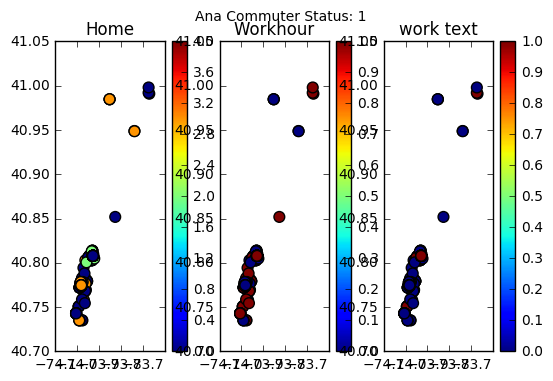

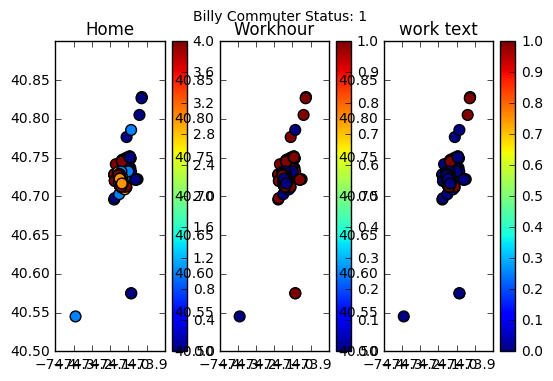

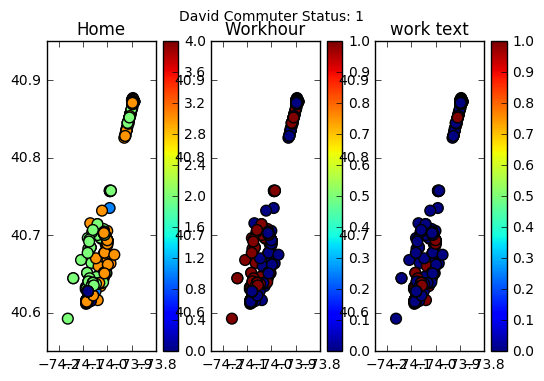

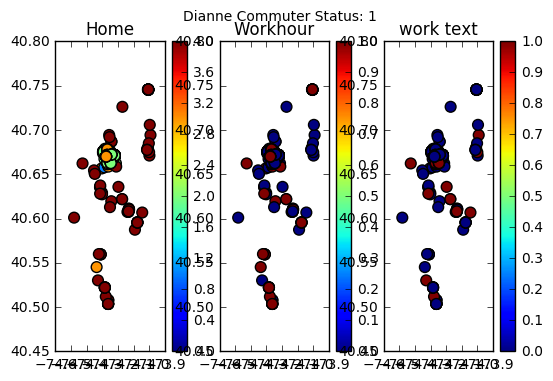

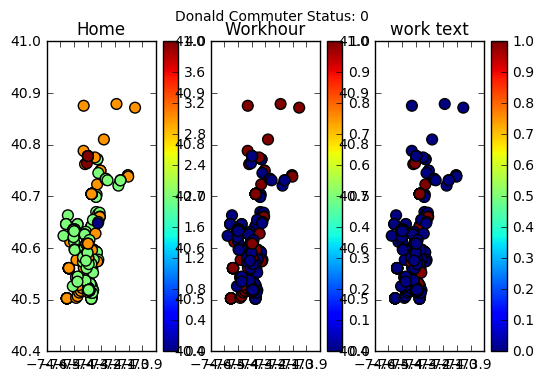

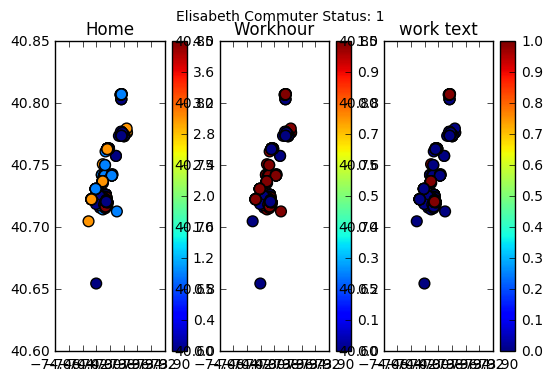

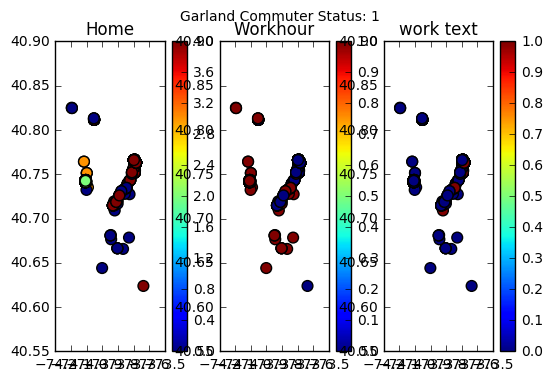

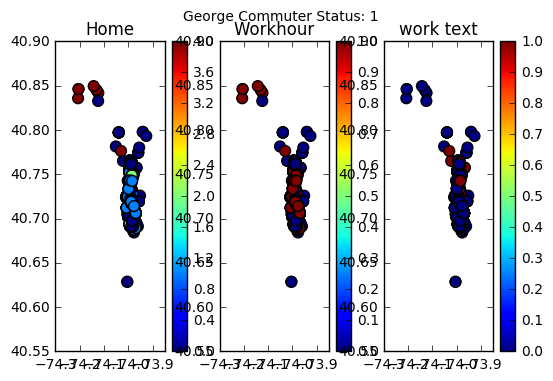

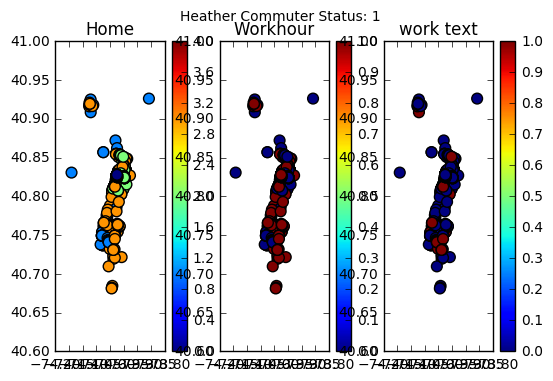

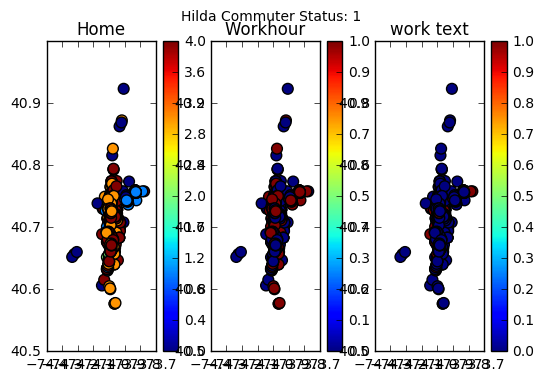

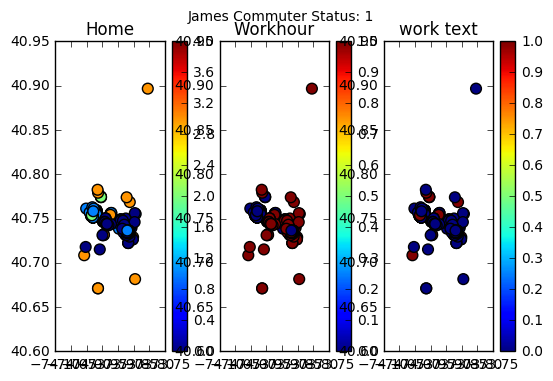

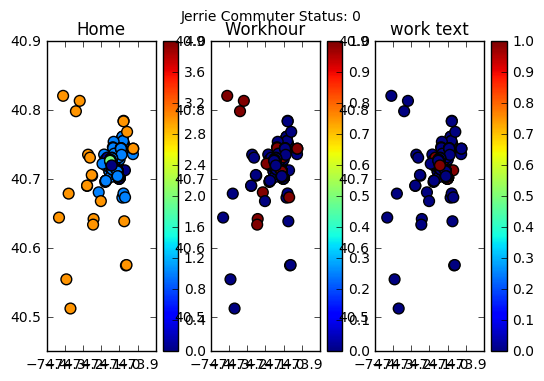

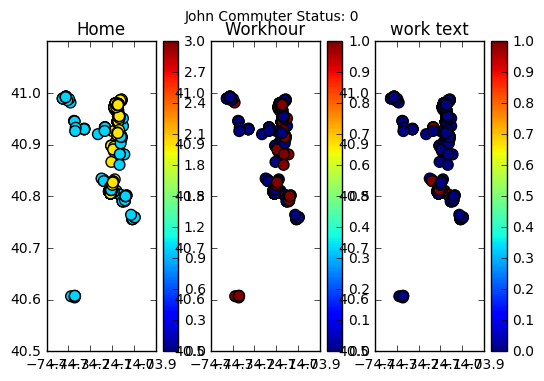

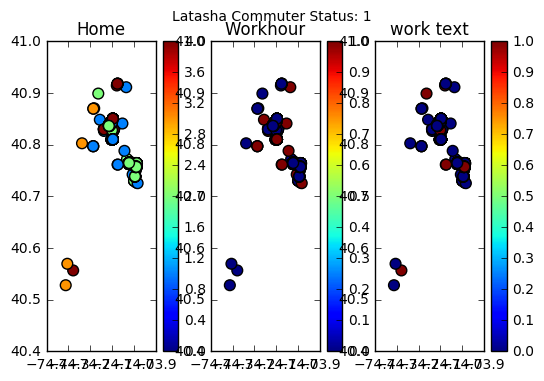

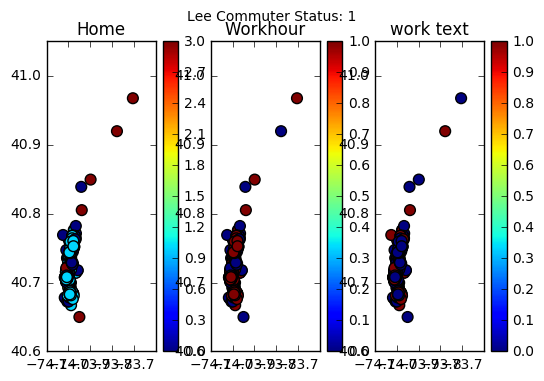

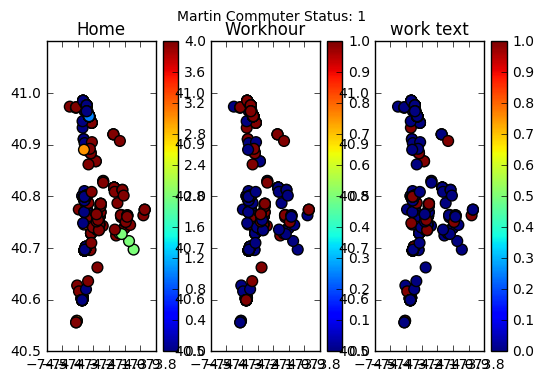

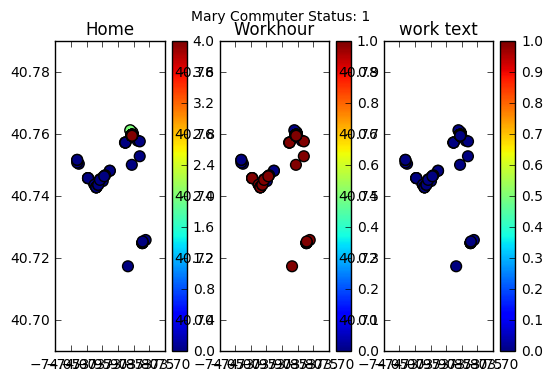

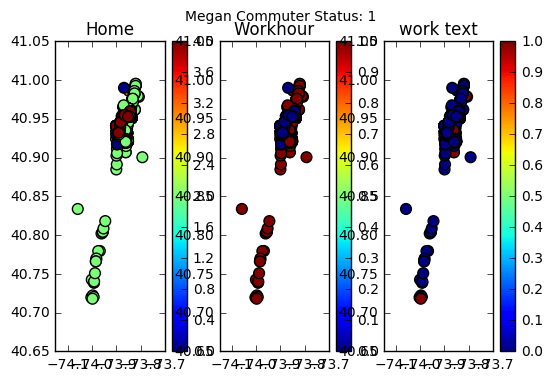

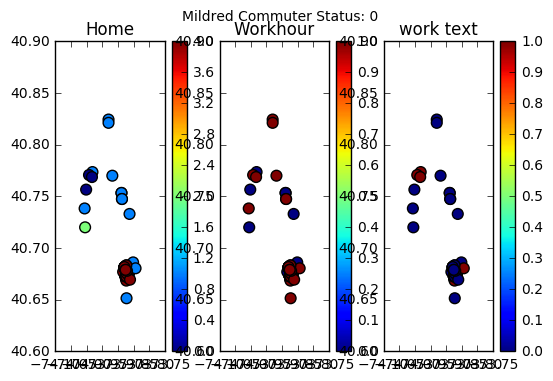

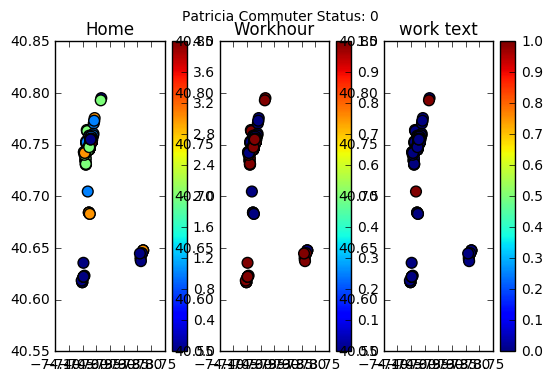

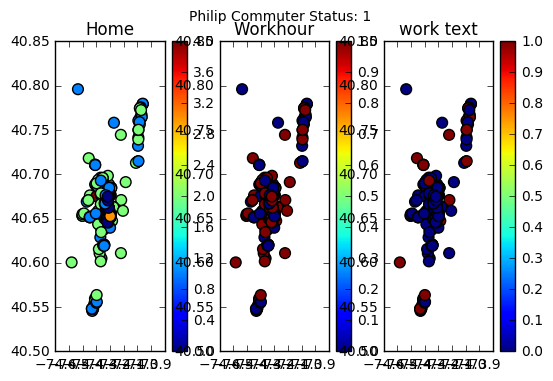

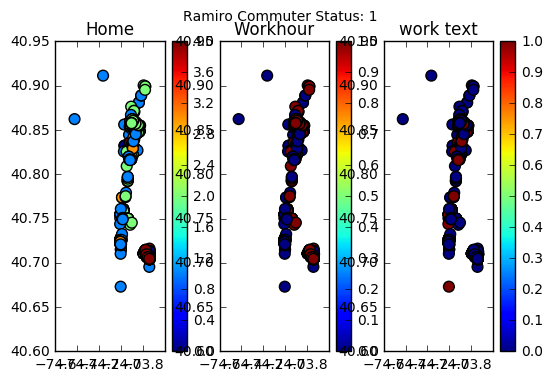

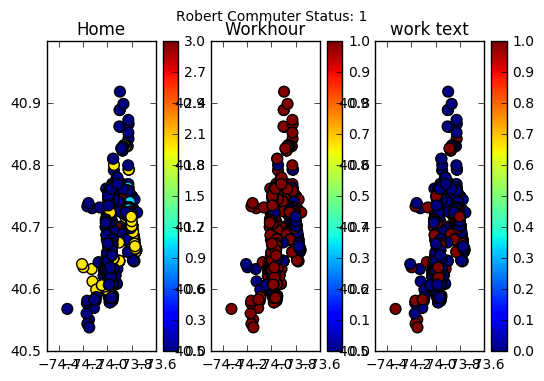

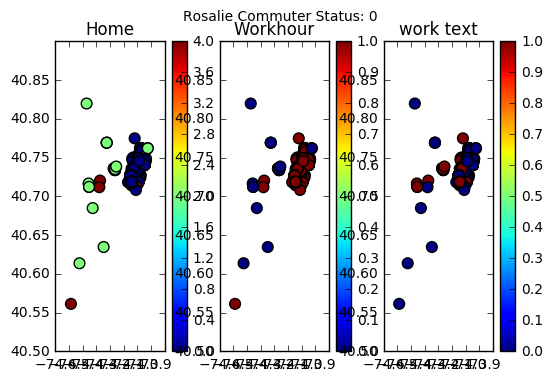

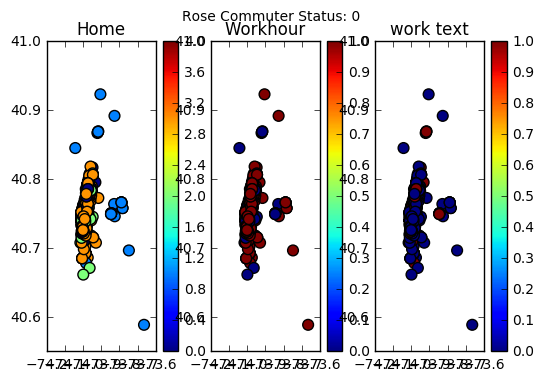

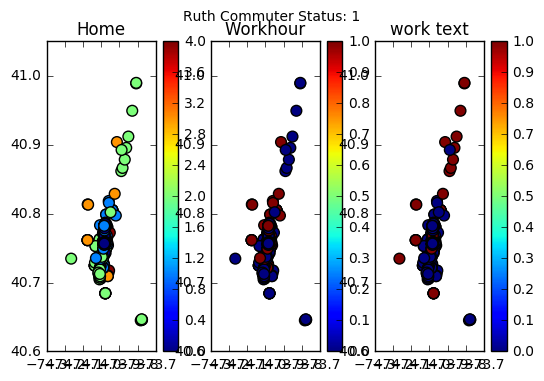

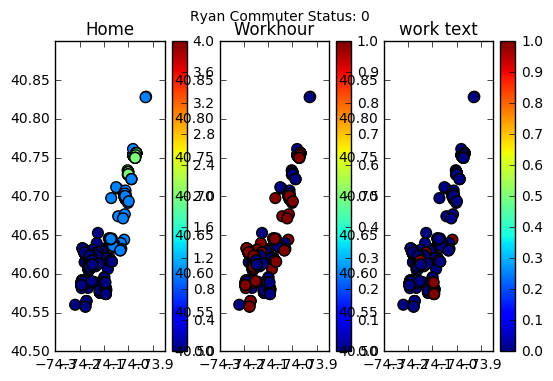

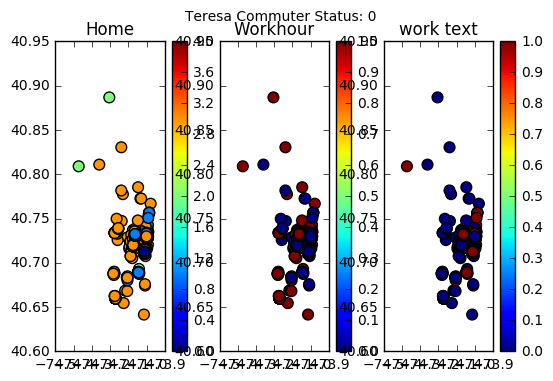

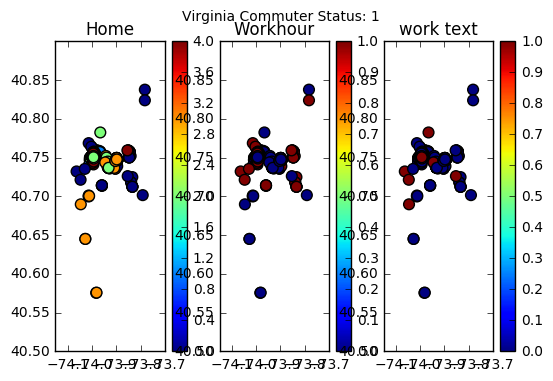

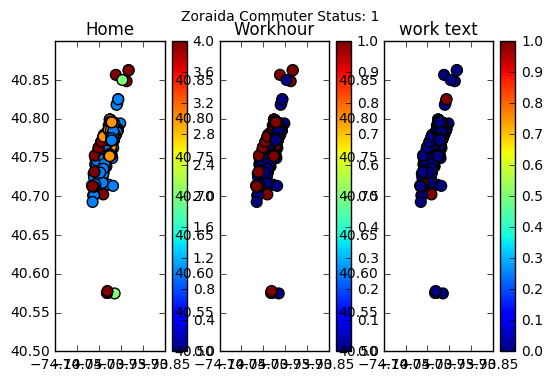

In [14]:
### Visually inspect commute vs. non-commute tags
###

# plot location by time of day and day of week for each person

for file_ in allFiles:
    d, boop = read_drew(file_)
    datetime_labels = [datetime.datetime.fromtimestamp( float(lab) ) for lab in d[:,2]]
    # hour of the day
    plt.subplot(1, 3, 1)
    plt.scatter(d[:,1], d[:,0], 60, d[:,6])
    plt.title('Home')
    plt.colorbar()

    # workhour?
    plt.subplot(1, 3, 2)
    plt.scatter(d[:,1], d[:,0], 60, d[:,5])
    plt.title('Workhour')
    plt.colorbar()    

    # work text?
    plt.subplot(1, 3, 3)
    plt.scatter(d[:,1], d[:,0], 60, d[:,4])
    plt.title('work text')
    plt.colorbar()    
    
    
    plt.suptitle(str(boop[0][0]) + ' Commuter Status: ' + str(boop[0][1]))
    plt.show()

In [355]:
# ## Fit a GMM -- all data together
# import itertools
# from scipy import linalg
# from sklearn import mixture
# from sklearn.externals.six.moves import xrange

# pers_num = df['name'].unique().shape[0]

# gmm = mixture.GMM(n_components=pers_num, covariance_type='full', n_iter=100)
# title = "Expectation-maximization"

# # excluding datetime, and text
# X = data[:,[0,1,3,4]]
# gmm.fit(X)
# print(df.shape)

# color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

# splot = plt.subplot(1, 1, 1)
# Y_ = gmm.predict(X)

# for i, (mean, covar, color) in enumerate(zip(gmm.means_, gmm._get_covars(), color_iter)):
#     v, w = linalg.eigh(covar)
#     u = w[0] / linalg.norm(w[0])
        
#     plt.scatter(X[Y_ == i, 3], X[Y_ == i, 2], .8, color=color)

#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan(u[1] / u[0])
#     angle = 180 * angle / np.pi  # convert to degrees
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(0.5)
#     splot.add_artist(ell)

# plt.title(title)







# ## Plot the data to see what's up
#     # categorize by name
# names = df.groupby('name')

# # plot
# fig, ax = plt.subplots()
# for name, group in names:
#     ax.plot(group.lon, group.lat, marker='.', linestyle='', ms=12, label=name)
# # ax.legend()

# plt.show()

In [361]:
# # create empty dictionary
# d = {}

# gmm = mixture.GMM(n_components=3, covariance_type='full', n_iter=500)

# # fill dictionary with prediction algorithms, one for eacgh person
# for file_ in allFiles:
#     name = file_.split('/',)[1].split('.')[0]
#     interim = data[data[:,6] == name]
#     X = interim[:,[0,1,3,4]]
#     d["gmm_{0}".format(name)] = gmm.fit(X)

In [793]:
# ## Fit a GMM -- one person at a time
# n = 1


# file_ = allFiles[n]
# name = file_.split('/',)[1].split('.')[0]

# X = data[data[:,6] == name]
# X = X[:,[0,1,3,4]]

# Y_ = d['gmm_' + name].predict(X)


# color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

# splot = plt.subplot(1, 1, 1)
# Y_ = gmm.predict(X)

# for i, (mean, covar, color) in enumerate(zip(gmm.means_, gmm._get_covars(), color_iter)):
#     v, w = linalg.eigh(covar)
#     u = w[0] / linalg.norm(w[0])
        
#     plt.scatter(X[Y_ == i, 3], X[Y_ == i, 2], .8, color=color)

#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan(u[1] / u[0])
#     angle = 180 * angle / np.pi  # convert to degrees
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(0.5)
#     splot.add_artist(ell)

# plt.title(title)